Download the data

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2020-11-09 18:34:30--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.35.36.46, 13.35.36.36, 13.35.36.125, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.35.36.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  8.17MB/s    in 0.3s    

2020-11-09 18:34:30 (8.17 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.t

In [ ]:
%matplotlib inline


Classifying Names with a Character-Level RNN
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import random

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string
import math

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
train_data = {}
validation_data = {}
test_data = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.7*len(lines)))]
    validation_data[category] = lines[int(math.floor(0.7*len(lines)))+1:int(math.floor(0.85*len(lines)))]
    test_data[category] = lines[int(math.floor(0.85*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Irish.txt', 'data/names/Czech.txt', 'data/names/Portuguese.txt', 'data/names/German.txt', 'data/names/Vietnamese.txt', 'data/names/Polish.txt', 'data/names/Chinese.txt', 'data/names/French.txt', 'data/names/Russian.txt', 'data/names/Dutch.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/English.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Arabic.txt', 'data/names/Korean.txt', 'data/names/Scottish.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [ ]:
print(category_lines['Italian'][:5])

['Marchetti', 'Salvaggi', 'Aloia', 'Rossini', 'Pisani']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [ ]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <http://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [ ]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, type):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        if type == 'linear':
          self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
          self.i2o = nn.Linear(input_size + hidden_size, output_size)
        elif type == 'GRU':
          self.i2h = nn.GRUCell(input_size + hidden_size, hidden_size)
          self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        
        self.i2h = nn.LSTMCell(input_size + hidden_size * 2, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, cell):
        combined_o = torch.cat((input, hidden), 1)
        combined_hc = torch.cat((input, hidden, cell), 1)
        hidden, cell = self.i2h(combined_hc)
        output = self.i2o(combined_o)
        output = self.softmax(output)
        return output, hidden, cell

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
      
    def initCell(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories, 'linear')    
GRU = RNN(n_letters, n_hidden, n_categories, 'GRU')   
lstm = LSTM(n_letters, n_hidden, n_categories)   

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [ ]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [ ]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9583, -2.7544, -2.9121, -2.8659, -2.9145, -2.9055, -2.8695, -2.8737,
         -2.8878, -2.8485, -2.8367, -2.9760, -2.9750, -2.9719, -2.8247, -2.8293,
         -2.8448, -3.0169]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [ ]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Czech', 1)


We will also want a quick way to get a training example (a name and its
language):




In [ ]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Arabic / line = Zogby
category = Vietnamese / line = Ta
category = Polish / line = Filipowski
category = Arabic / line = Morcos
category = Italian / line = Albero
category = Czech / line = Svocak
category = Dutch / line = Peerenboom
category = Polish / line = Zuraw
category = Chinese / line = Kuai
category = Portuguese / line = Soares


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [ ]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [ ]:
optimizer = torch.optim.Adam(rnn.parameters())
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    # reset gradient
    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer.step()

    return output, loss.item()

optimizer_GRU = torch.optim.Adam(GRU.parameters())
def train_GRU(category_tensor, line_tensor):
    hidden = GRU.initHidden()

    GRU.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = GRU(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer_GRU.step()

    return output, loss.item()

optimizer_LSTM = torch.optim.Adam(lstm.parameters())
def train_LSTM(category_tensor, line_tensor):
    hidden = lstm.initHidden()
    cell = lstm.initCell()

    lstm.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden, cell = lstm(line_tensor[i], hidden, cell)

    loss = criterion(output, category_tensor)

    # compute gradient by backpropagation
    loss.backward()

    # update parameters
    optimizer_LSTM.step()

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [ ]:
import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss = 0
all_train_losses = []
all_validation_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

def eval_dataset(dataset):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate(line_tensor)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion
  
print('\nIter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    train_loss += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses.append(train_loss / plot_every)
        train_loss = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss, _ = eval_dataset(validation_data)

        # save model with best validation loss
        if len(all_validation_losses) == 0 or average_validation_loss < min(all_validation_losses):
            torch.save(rnn, 'char_rnn_classification_model.pt')
        all_validation_losses.append(average_validation_loss)



Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 20s) 	1.8347 		Cnaimhin / Russian ✗ (Irish)
10000 	12% 	(0m 44s) 	1.5337 		Gwozdek / Polish ✓
15000 	18% 	(1m 7s) 	1.4692 		Tannous / French ✗ (Arabic)
20000 	25% 	(1m 31s) 	1.3553 		Meeuwe / Japanese ✗ (Dutch)
25000 	31% 	(1m 55s) 	1.3447 		Fabian / French ✓
30000 	37% 	(2m 18s) 	1.2997 		Ping / Chinese ✓
35000 	43% 	(2m 42s) 	1.1933 		Nifterik / Dutch ✓
40000 	50% 	(3m 7s) 	1.2729 		Castro / Portuguese ✓
45000 	56% 	(3m 31s) 	1.2562 		Shiokawa / Japanese ✓
50000 	62% 	(3m 54s) 	1.2333 		Doan / Vietnamese ✓
55000 	68% 	(4m 17s) 	1.2240 		O'Ryan / Irish ✓
60000 	75% 	(4m 41s) 	1.1252 		Araullo / Portuguese ✓
65000 	81% 	(5m 4s) 	1.1595 		Yun / Chinese ✗ (Korean)
70000 	87% 	(5m 28s) 	1.1296 		Rowe / Scottish ✗ (English)
75000 	93% 	(5m 51s) 	1.1699 		Abategiovanni / Greek ✗ (Italian)
80000 	100% 	(6m 15s) 	1.1963 		Schneider / Czech ✗ (German)


GRU

In [ ]:
import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss_GRU = 0
all_train_losses_GRU = []
all_validation_losses_GRU = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate(line_tensor):
    hidden = GRU.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = GRU(line_tensor[i], hidden)
    return output

def eval_dataset(dataset):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate(line_tensor)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion
  
print('\nIter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_GRU(category_tensor, line_tensor)
    train_loss_GRU += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss_GRU / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_GRU.append(train_loss_GRU / plot_every)
        train_loss_GRU = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss, _ = eval_dataset(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_GRU) == 0 or average_validation_loss < min(all_validation_losses_GRU):
            torch.save(GRU, 'char_rnn_classification_model_GRU.pt')
        all_validation_losses_GRU.append(average_validation_loss)


Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(0m 55s) 	1.8387 		Mckenzie / Greek ✗ (Scottish)
10000 	12% 	(1m 57s) 	1.4119 		Ramakers / Dutch ✓
15000 	18% 	(2m 59s) 	1.1661 		Tsukahara / Japanese ✓
20000 	25% 	(4m 1s) 	0.9573 		Portnov / Russian ✓
25000 	31% 	(5m 2s) 	0.8236 		Rocha / Portuguese ✗ (Spanish)
30000 	37% 	(6m 5s) 	0.7287 		Han / Chinese ✗ (Vietnamese)
35000 	43% 	(7m 7s) 	0.6900 		Salib / Arabic ✓
40000 	50% 	(8m 10s) 	0.6182 		Pierre / French ✓
45000 	56% 	(9m 11s) 	0.5510 		Hamada / Japanese ✓
50000 	62% 	(10m 16s) 	0.5189 		Cowell / English ✓
55000 	68% 	(11m 18s) 	0.4465 		Driscoll / Russian ✗ (English)
60000 	75% 	(12m 19s) 	0.4562 		Yun / Korean ✓
65000 	81% 	(13m 21s) 	0.4246 		Peng / Chinese ✓
70000 	87% 	(14m 23s) 	0.3627 		Habarov / Russian ✓
75000 	93% 	(15m 24s) 	0.4194 		Malone / Irish ✓
80000 	100% 	(16m 25s) 	0.3700 		Rossum / Dutch ✓


LSTM

In [ ]:
import time
import math

n_iters = 80000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
train_loss_LSTM = 0
all_train_losses_LSTM = []
all_validation_losses_LSTM = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Just return an output given a line
def evaluate_LSTM(line_tensor):
    hidden = lstm.initHidden()
    cell = lstm.initCell()

    for i in range(line_tensor.size()[0]):
        output, hidden, cell = lstm(line_tensor[i], hidden, cell)
    return output

def eval_dataset_LSTM(dataset):
    loss = 0
    n_instances = 0
    confusion = torch.zeros(n_categories, n_categories)
    for category in all_categories:
        category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
        n_instances += len(dataset[category])
        for line in dataset[category]:
            line_tensor = Variable(lineToTensor(line))
            output = evaluate_LSTM(line_tensor)
            loss += criterion(output, category_tensor)
            guess, guess_i = categoryFromOutput(output)
            category_i = all_categories.index(category)
            confusion[category_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    return loss.item() / n_instances, confusion
  
print('\nIter \tTrain% \tTime \t\tTrain_loss \tExample')
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_LSTM(category_tensor, line_tensor)
    train_loss_LSTM += loss

    # Print iter number, train loss average, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d \t%d%% \t(%s) \t%.4f \t\t%s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), train_loss_LSTM / plot_every, line, guess, correct))

    # Add current train loss average to list of losses
    if iter % plot_every == 0:
        all_train_losses_LSTM.append(train_loss_LSTM / plot_every)
        train_loss_LSTM = 0
        
    # Compute loss based on validation data
    if iter % plot_every == 0:
        average_validation_loss, _ = eval_dataset_LSTM(validation_data)

        # save model with best validation loss
        if len(all_validation_losses_LSTM) == 0 or average_validation_loss < min(all_validation_losses_LSTM):
            torch.save(lstm, 'char_rnn_classification_model_lstm.pt')
        all_validation_losses_LSTM.append(average_validation_loss)


Iter 	Train% 	Time 		Train_loss 	Example
5000 	6% 	(1m 9s) 	1.9248 		Lauwens / French ✗ (Dutch)
10000 	12% 	(2m 25s) 	1.4792 		Daele / English ✗ (Dutch)
15000 	18% 	(3m 40s) 	1.1223 		Takishida / Japanese ✓
20000 	25% 	(4m 56s) 	1.0290 		Mcguire / Irish ✓
25000 	31% 	(6m 14s) 	0.8921 		Lecuyer / German ✗ (French)
30000 	37% 	(7m 31s) 	0.7729 		Vo / Vietnamese ✓
35000 	43% 	(8m 46s) 	0.6986 		Monahan / Irish ✓
40000 	50% 	(10m 1s) 	0.6560 		Zhai / Chinese ✓
45000 	56% 	(11m 15s) 	0.6007 		Churchill / English ✓
50000 	62% 	(12m 29s) 	0.5503 		Mingo / Italian ✗ (Spanish)
55000 	68% 	(13m 43s) 	0.6172 		Nahas / Arabic ✓
60000 	75% 	(14m 59s) 	0.4775 		Mcintosh / Scottish ✓
65000 	81% 	(16m 14s) 	0.5322 		Sugawara / Japanese ✓
70000 	87% 	(17m 30s) 	0.4862 		Jon / Korean ✓
75000 	93% 	(18m 46s) 	0.4513 		Sommer / German ✓
80000 	100% 	(20m 1s) 	0.5024 		Close / Greek ✓


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




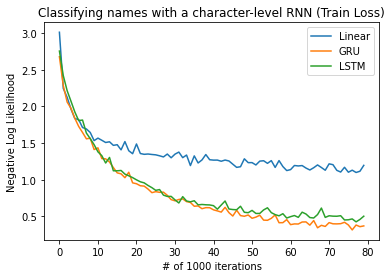

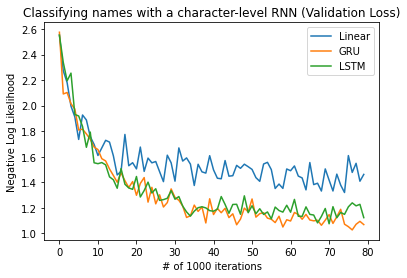

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_train_losses)
plt.plot(all_train_losses_GRU)
plt.plot(all_train_losses_LSTM)
plt.title('Classifying names with a character-level RNN (Train Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(['Linear', 'GRU', 'LSTM'], loc='upper right')


plt.figure()
plt.plot(all_validation_losses)
plt.plot(all_validation_losses_GRU)
plt.plot(all_validation_losses_LSTM)
plt.title('Classifying names with a character-level RNN (Validation Loss)')
plt.ylabel('Negative Log Likelihood')
plt.xlabel('# of 1000 iterations')
plt.legend(['Linear', 'GRU', 'LSTM'], loc='upper right')


Based on the graph and data above, GRU use less training parameters and therefore use less memory, execute faster and train faster than LSTM's whereas LSTM is more accurate on dataset using longer sequence. Both of them have a much better performance than linear because their algorithm is more complicated to gain a more accurate solution.

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




Average test loss of linear: 1.107831406458264
Average test loss of GRU: 1.0709211024710512
Average test loss of LSTM: 1.0709211024710512


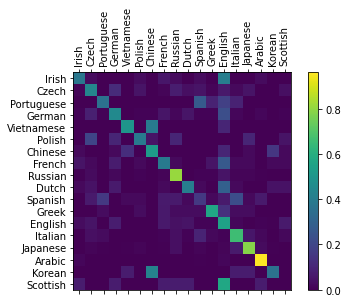

In [ ]:
# evaluate on test set and display confusion matrix
rnn = torch.load('char_rnn_classification_model.pt')
average_test_loss, confusion = eval_dataset(test_data)
print('Average test loss of linear: ' + str(average_test_loss))

GRU = torch.load('char_rnn_classification_model_GRU.pt')
average_test_loss_GRU, confusion = eval_dataset_GRU(test_data)
print('Average test loss of GRU: ' + str(average_test_loss_GRU))

lstm = torch.load('char_rnn_classification_model_lstm.pt')
average_test_loss_LSTM, confusion = eval_dataset_LSTM(test_data)
print('Average test loss of LSTM: ' + str(average_test_loss_LSTM))

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.37) Russian
(-1.47) Czech
(-3.18) English

> Jackson
(-1.08) Czech
(-1.22) English
(-1.57) Russian

> Satoshi
(-0.09) Japanese
(-3.26) Polish
(-4.01) Arabic


The final versions of the scripts `in the Practical PyTorch
repo <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
split the above code into a few files:

-  ``data.py`` (loads files)
-  ``model.py`` (defines the RNN)
-  ``train.py`` (runs training)
-  ``predict.py`` (runs ``predict()`` with command line arguments)
-  ``server.py`` (serve prediction as a JSON API with bottle.py)

Run ``train.py`` to train and save the network.

Run ``predict.py`` with a name to view predictions:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON
output of predictions.




Exercises
=========

-  Try with a different dataset of line -> category, for example:

   -  Any word -> language
   -  First name -> gender
   -  Character name -> writer
   -  Page title -> blog or subreddit

-  Get better results with a bigger and/or better shaped network

   -  Add more linear layers
   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network


